# The Effectiveness of Edge Detection Evaluation Metrics for Automated Coastline Detection
<br>
Conor O'Sullivan 
<br>
27 Feb 2023

In [26]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import glob
from skimage import feature

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi

# Import helper functions from utils.py
import utils 

#Save path 
save_path = '~/Google Drive/My Drive/UCD/research/Evaluation metrics/'


In [27]:
# Reload utils
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL MONITORING/edge-detection-metrics/src/utils.py'>

## Load images and edge reference

In [28]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Load all images and labels
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = utils.load_test(path)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

# Apply canny edge detection to binary maps to get reference edges
canny_input = [np.uint8(img*255) for img in labels]
edge_reference = [np.uint8(cv2.Canny(img,threshold1 = 100, threshold2 = 200)) for img in canny_input]

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


0 255


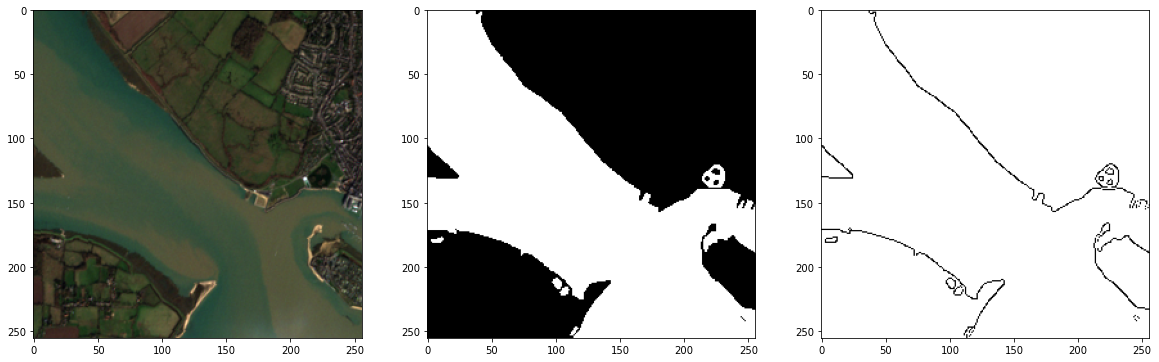

In [30]:
# Sense check edge references
rint = np.random.randint(0,len(edge_reference))

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(rgb[rint])
ax[1].imshow(labels[rint], cmap='gray')
ax[2].imshow(255-edge_reference[rint], cmap='gray')

print(np.min(edge_reference[rint]) ,np.max(edge_reference[rint]))

## Apply canny edge detection and evaluation metrics

In [108]:
# Apply canny edge detection with different intensity thresholds
thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]

canny_input = input.copy()
canny = {}

for threshold in thresholds:
        t1 = threshold[0]
        t2 = threshold[1]
        canny[str(threshold)] = [utils.canny_ed(img,threshold1=t1,threshold2=t2) for img in canny_input]

        print(threshold, len(canny[str(threshold)]),'done')

[50, 100] 98 done
[50, 150] 98 done
[100, 200] 98 done
[100, 300] 98 done
[200, 400] 98 done
[200, 600] 98 done


In [56]:
# Evaluate canny edge detection with rmse, psnr, uqi, ssim and fom
rows = []

for threshold in thresholds:
    canny_output = canny[str(threshold)]

    for i, output in enumerate(canny_output):
        ref_img = edge_reference[i]
        ID = "IMG#{}".format(i)

        for j in range(len(utils.channels)):
                
            img = output[:,:,j]

            # Evaluation metrics
            rmse_ = rmse(ref_img,img)
            psnr_ = psnr(ref_img,img)
            uqi_ = uqi(ref_img,img)
            ssim_ = ssim(ref_img,img,multichannel=True)
            fom_ = utils.fom(ref_img,img)

            # detect edges as a percentage of reference edges
            pde_ = np.count_nonzero(img)/np.count_nonzero(ref_img)
            
            row = [ID,str(threshold),j+ 1,rmse_,psnr_,uqi_,ssim_,fom_,pde_]
            rows.append(row)

    print(threshold,'done')

    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","band","rmse","psnr","uqi","ssim","fom","pde"])
df_metrics.to_csv(save_path+"canny_evaluation_metrics.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_44294/3885972577.py:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


[50, 100] done
[50, 150] done
[100, 200] done
[100, 300] done
[200, 400] done
[200, 600] done


,ID,thresholds,band,rmse,psnr,uqi,ssim,fom,pde
0,IMG#0,"[50, 100]",1,82.603743,9.790809,0.399616,0.587947,0.199321,2.889844
1,IMG#0,"[50, 100]",2,99.235137,8.197494,0.376802,0.522827,0.171326,4.648039
2,IMG#0,"[50, 100]",3,100.822206,8.059680,0.374659,0.513517,0.174718,4.839334
3,IMG#0,"[50, 100]",4,105.510734,7.664871,0.367451,0.481393,0.196217,5.612574
4,IMG#0,"[50, 100]",5,90.458256,9.001839,0.384508,0.557746,0.229358,3.948415


## Analyse metric trend

In [33]:
df_metrics = pd.read_csv(save_path+"canny_evaluation_metrics.csv")
df_metrics.head()

,Unnamed: 0,ID,thresholds,band,rmse,psnr,uqi,ssim,fom
0,0,IMG#0,"[50, 100]",1,82.603743,9.790809,0.399616,0.587947,0.199321
1,1,IMG#0,"[50, 100]",2,99.235137,8.197494,0.376802,0.522827,0.171326
2,2,IMG#0,"[50, 100]",3,100.822206,8.059680,0.374659,0.513517,0.174718
3,3,IMG#0,"[50, 100]",4,105.510734,7.664871,0.367451,0.481393,0.196217
4,4,IMG#0,"[50, 100]",5,90.458256,9.001839,0.384508,0.557746,0.229358


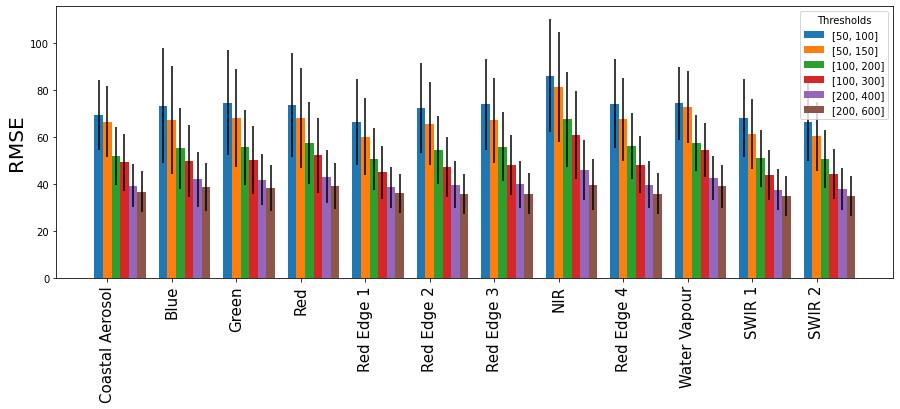

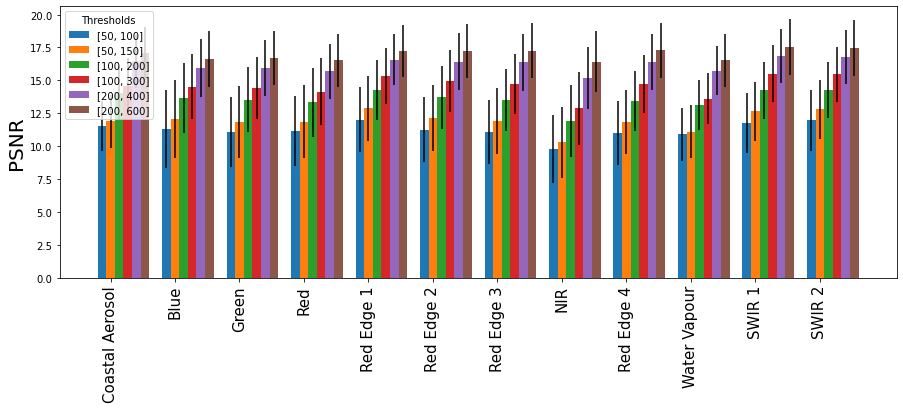

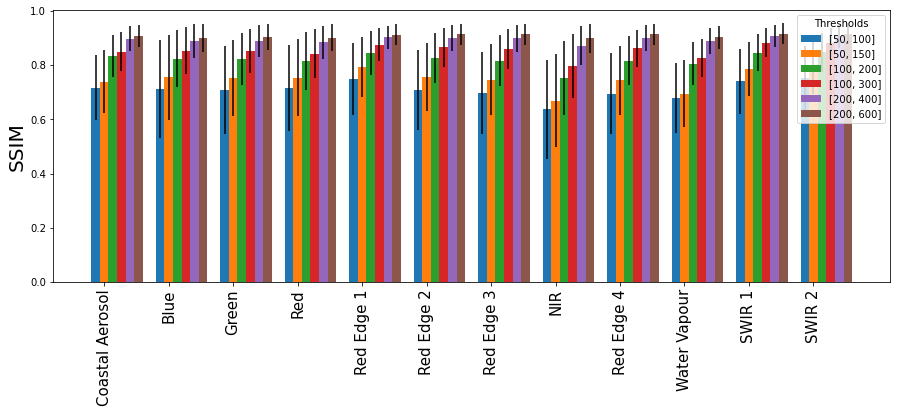

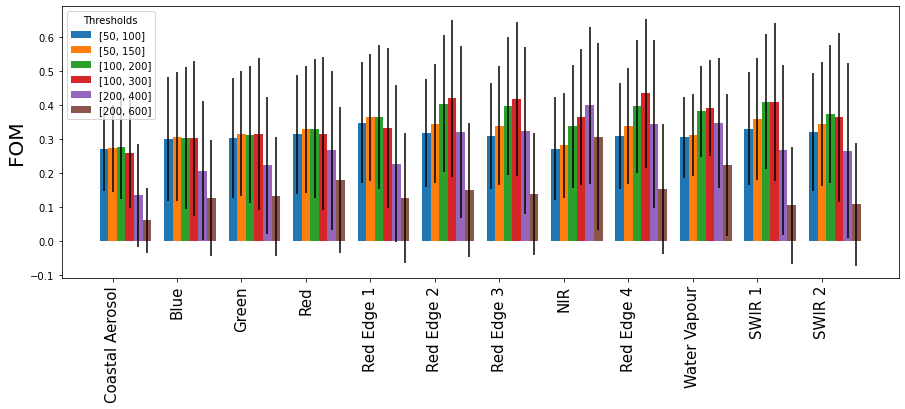

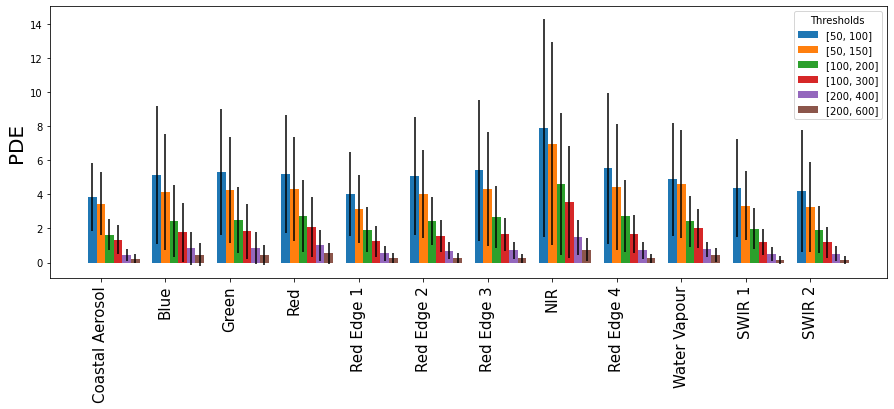

In [104]:
# metric trends
utils.plot_metric_trends(df_metrics,'rmse')
utils.plot_metric_trends(df_metrics,'psnr')
utils.plot_metric_trends(df_metrics,'ssim')
utils.plot_metric_trends(df_metrics,'fom')
utils.plot_metric_trends(df_metrics,'pde')


In [103]:
# counts of best thresholds
best_threshold_count = pd.DataFrame(thresholds,columns=['threshold1','threshold2'])

for metric in ['rmse','psnr','ssim','fom']:

    df = df_metrics[['ID','thresholds',metric]]

    if metric == 'rmse':
        best_thresholds = df.loc[df.groupby('ID')[metric].idxmin()]
    else:
        best_thresholds = df.loc[df.groupby('ID')[metric].idxmax()]

    count = []
    for threshold in thresholds:
        df = best_thresholds[best_thresholds['thresholds']==str(threshold)]
        count.append(len(df))

    best_threshold_count[metric] = count

best_threshold_count 

,threshold1,threshold2,rmse,psnr,ssim,fom
0,50,100,0,0,0,2
1,50,150,0,0,0,7
2,100,200,2,2,2,12
3,100,300,1,1,3,31
4,200,400,4,4,20,30
5,200,600,91,91,73,16


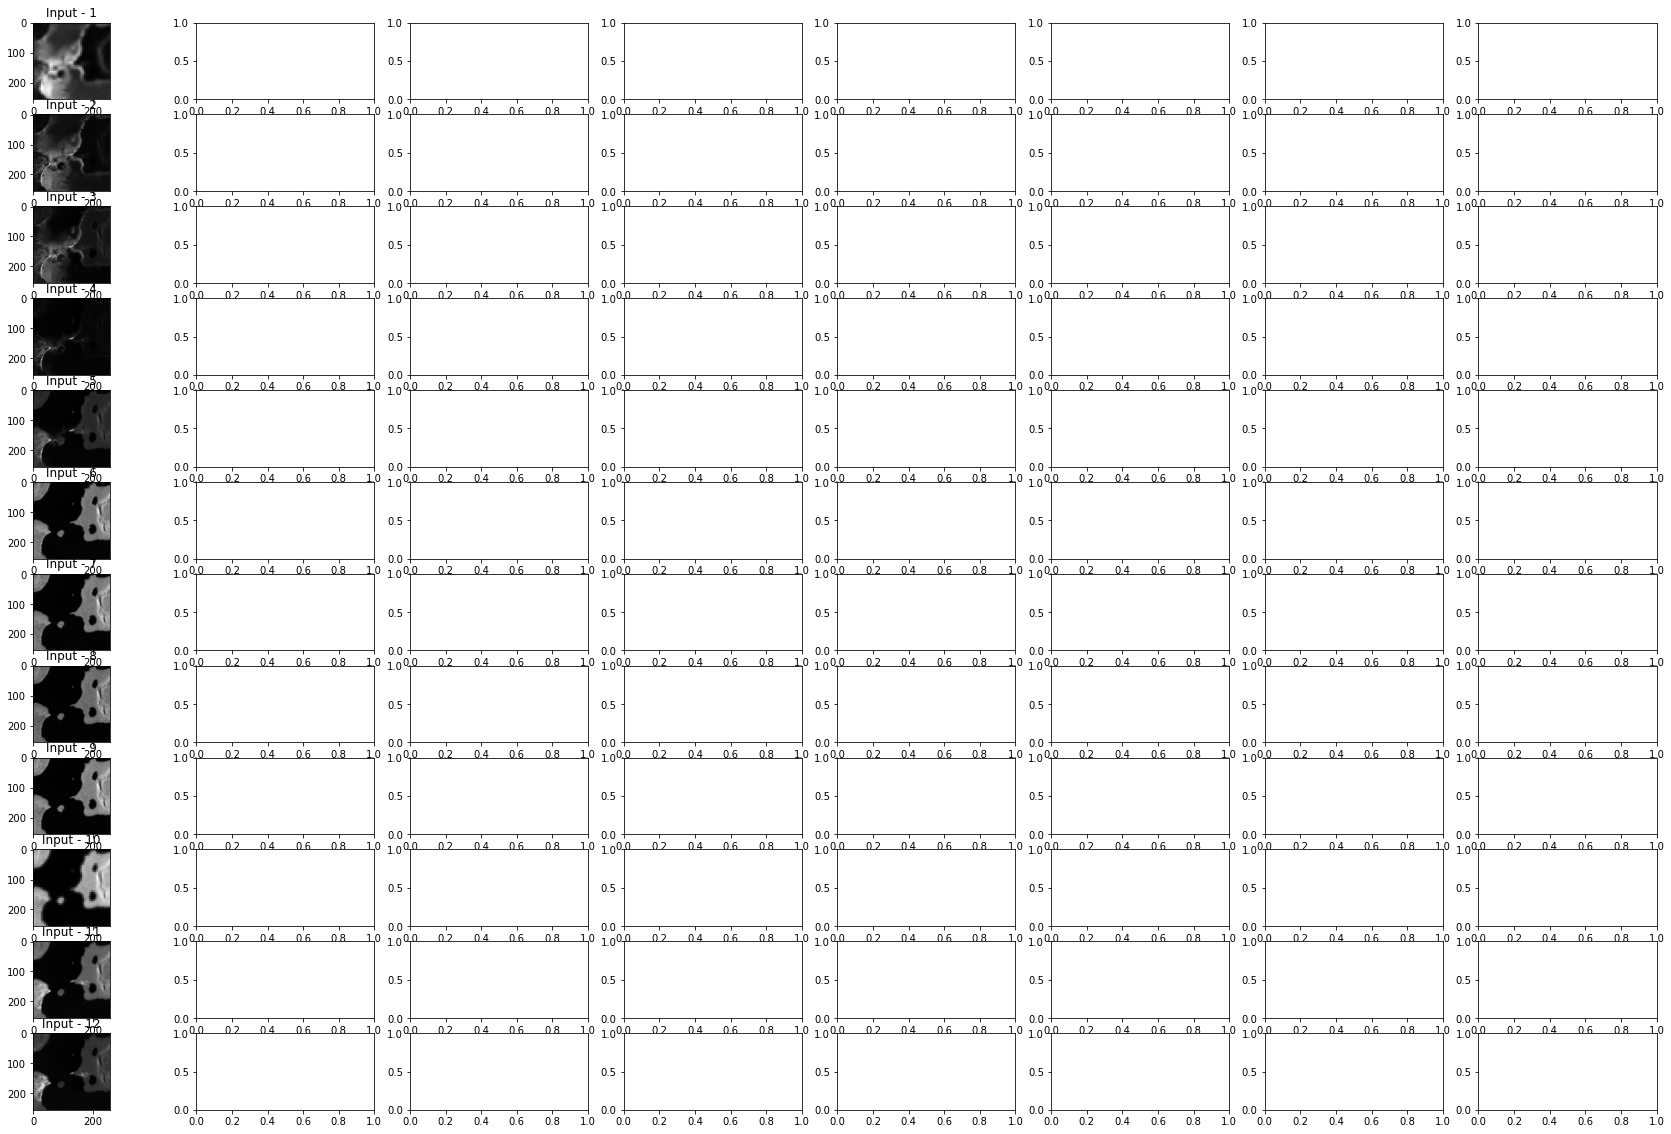

In [113]:
fig, axs = plt.subplots(12, 8, figsize=(30, 20))
fig.set_facecolor('white')
#rint = np.random.randint(0, len(input))
rint = 67

ref_img = edge_reference[rint]

for i, channel in enumerate(utils.channels):
    axs[i, 0].imshow(input[rint][:, :, i], cmap='gray')
    axs[i, 0].set_title('Input - {}'.format(i + 1))

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_44294/1496430591.py:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


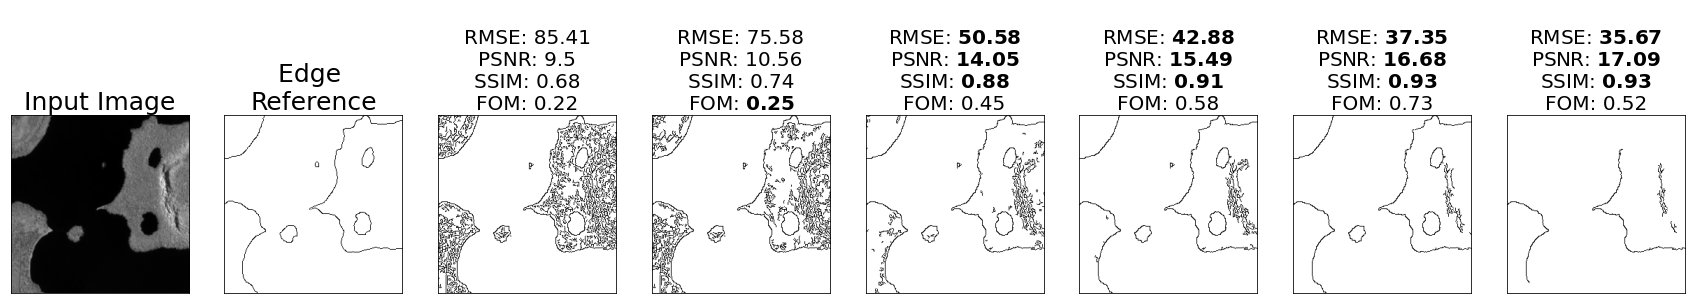

In [114]:
fig, axs = plt.subplots(1, 8, figsize=(30, 20))
fig.set_facecolor('white')
#rint = np.random.randint(0, len(input))
rint = 67

band = 7 #NIR

img_input = input[rint].copy()

axs[0].imshow(img_input[:,:,band],cmap="gray")
axs[0].set_title("Input Image",size=25)

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge \nReference",size=25)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

for i,threshold in enumerate(thresholds):
        
    t1 = threshold[0]
    t2 = threshold[1]
    canny = utils.canny_ed(img_input,threshold1=t1,threshold2=t2)
    img = canny[:,:,band]
    
    axs[i+2].imshow(255-img,cmap="gray")
    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(utils.fom(ref_img,img),2)

    if i == 0:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(rmse_,psnr_,ssim_,fom_),size=20)
    elif i == 1:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: ".format(rmse_,psnr_,ssim_)+ r"$\bf{" + str(fom_) + "}$",size=20)
    else:
        axs[i+2].set_title("\nRMSE: " + r"$\bf{" + str(rmse_) + "}$" + 
        "\nPSNR: " + r"$\bf{" + str(psnr_) + "}$" +
        "\nSSIM: " + r"$\bf{" + str(ssim_) + "}$" +
        "\nFOM: " +str(fom_),size=20)

    #plt.savefig(fig_path.format("abstract.png"),bbox_inches="tight")    

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_48585/378155489.py:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


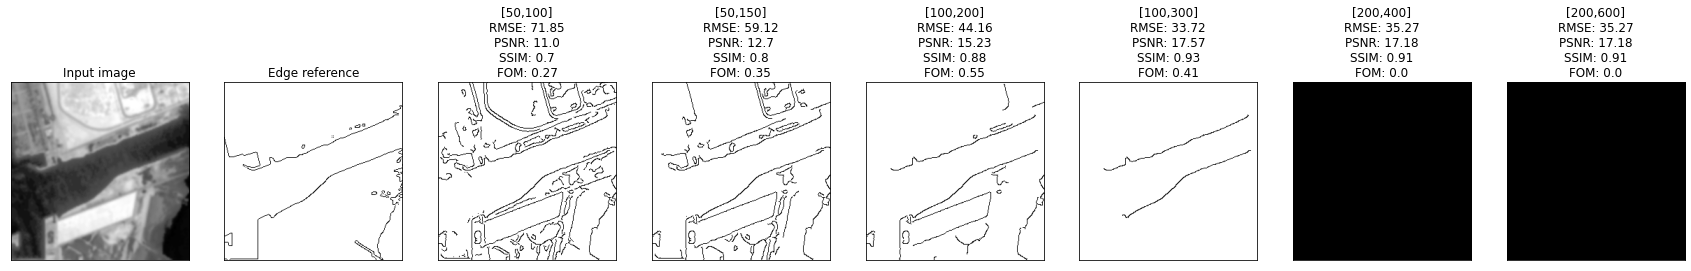

In [68]:
fig, axs = plt.subplots(1, 8, figsize=(30, 20))
fig.set_facecolor('white')
rint = np.random.randint(0, len(input))

band = 10 #blue

preprocess_input = input[rint].copy()
preprocess_input = preprocess(preprocess_input)

axs[0].imshow(preprocess_input[:,:,band],cmap="gray")
axs[0].set_title("Input image")

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge reference")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

for i,threshold in enumerate(thresholds):
        
    t1 = threshold[0]
    t2 = threshold[1]
    canny = canny_ed(preprocess_input,threshold1=t1,threshold2=t2)
    img = canny[:,:,band]
    
    axs[i+2].imshow(255-img,cmap="gray")
    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(fom(ref_img,img),2)
                
    axs[i+2].set_title("[{},{}]\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(t1,t2,rmse_,psnr_,ssim_,fom_))

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_48585/3587505056.py:18: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


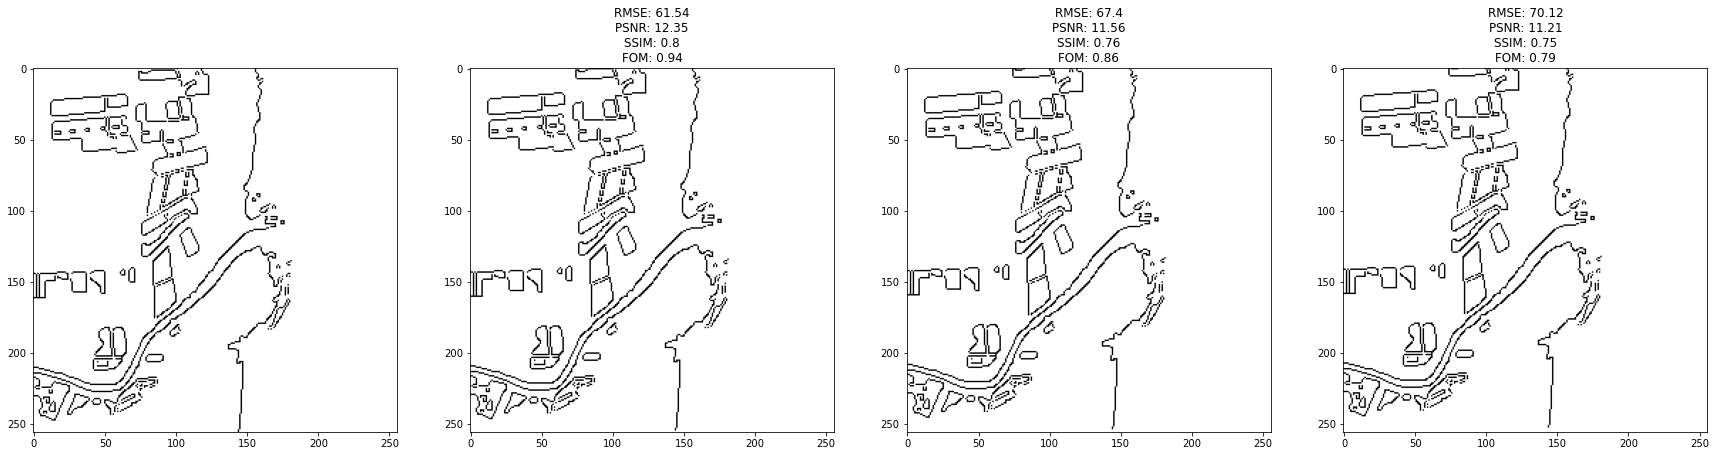

In [88]:
rint = np.random.randint(0, len(input))

band = 10 #blue
fig, axs = plt.subplots(1, 4, figsize=(30, 20))

ref_img = edge_reference[rint]
axs[0].imshow(255-ref_img,cmap="gray")

img = ref_img.copy()

for i in range(3):

    img = img[1:]
    img = np.vstack([img,[0]*256])

    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(fom(ref_img,img),2)


    axs[i+1].imshow(255-img,cmap="gray")
    axs[i+1].set_title("RMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(rmse_,psnr_,ssim_,fom_))

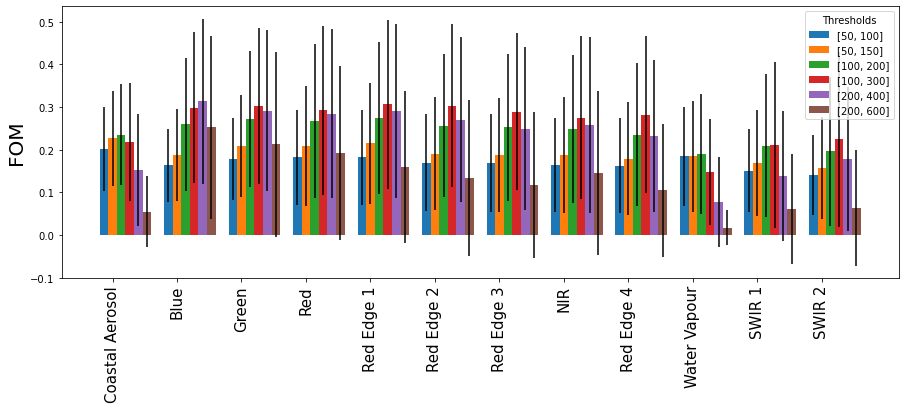

In [16]:
mean =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).mean()
sd =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).std()
metric = "fom"
global channels

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]

fig,ax = plt.subplots(1,1,figsize=(15,5))

w = 0.4
for i,thresh in enumerate(thresholds):

    bands = mean[mean.thresholds==str(thresh)]["band"]

    mean_i = mean[mean.thresholds==str(thresh)][metric]
    sd_i = sd[sd.thresholds==str(thresh)][metric]
    
    plt.bar(bands-w/3+i*w/3,mean_i,yerr=sd_i,width=w/3,label=str(thresh))

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend(title="Thresholds")

# Figure for abstract

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_44294/3063138381.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = round(ssim(ref_img,img,multichannel=True),2)


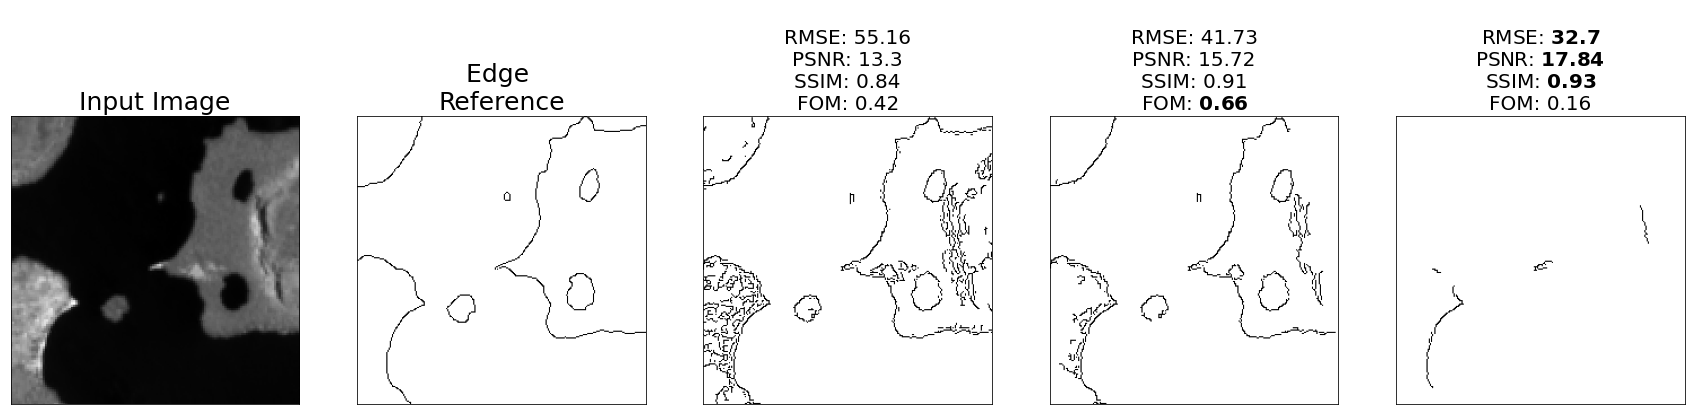

In [106]:
fig, axs = plt.subplots(1, 5, figsize=(30, 20))
fig.set_facecolor('white')
#rint = np.random.randint(0, len(input))
rint = 67

thresholds = [[50,100],[100,200],[200,400]]

band = 10 

img_input = input[rint].copy()
#img_input = preprocess(img_input,[False,False,False])

axs[0].imshow(img_input[:,:,band],cmap="gray")
axs[0].set_title("Input Image",size=25)

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge \nReference",size=25)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

for i,threshold in enumerate(thresholds):
        
    t1 = threshold[0]
    t2 = threshold[1]
    canny = utils.canny_ed(img_input,threshold1=t1,threshold2=t2)
    img = canny[:,:,band]
    
    axs[i+2].imshow(255-img,cmap="gray")
    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(utils.fom(ref_img,img),2)

    if i == 0:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(rmse_,psnr_,ssim_,fom_),size=20)
    elif i == 1:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: ".format(rmse_,psnr_,ssim_)+ r"$\bf{" + str(fom_) + "}$",size=20)
    else:
        axs[i+2].set_title("\nRMSE: " + r"$\bf{" + str(rmse_) + "}$" + 
        "\nPSNR: " + r"$\bf{" + str(psnr_) + "}$" +
        "\nSSIM: " + r"$\bf{" + str(ssim_) + "}$" +
        "\nFOM: " +str(fom_),size=20)

    #plt.savefig(fig_path.format("abstract.png"),bbox_inches="tight")    